##### Library Imports

In [84]:
import holidays
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from pylab import rcParams
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from statsmodels.tsa.seasonal import STL
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
def grouped(df, key, freq, col):
    """
    Computing moving average of the time series for a given frequency
    """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [3]:
def add_time(df, key, freq, col):
    """
    Adding a linear time step based on the given frequency for grouping 
    """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [4]:
def add_lag(df, key, freq, col, lag):
    """
    Shifting a time series by a given time step
    """
    df_grouped = grouped(df, key, freq, col)
    name = 'Lag_' + str(lag)
    df_grouped[name] = df_grouped['mean'].shift(lag)
    return df_grouped

In [5]:
def make_continuous_plot(feature):
    """
    Plotting scatter plot and its boxcox (1+x) transformation for a given continuous variable 
    feature against the target variable.
    """
    
    fig = plt.figure(figsize=(20,12))
    fig.subplots_adjust(hspace=.3)
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=data_sales['sold_qty_units'], 
                        x=boxcox1p(data_sales[feature], 0.15), ax=fig.add_subplot(gs[1,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(data_sales['sold_qty_units'].corr(boxcox1p(data_sales[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(data_sales[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=data_sales['sold_qty_units'], 
                        x=boxcox1p(data_sales[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(data_sales['sold_qty_units'].corr(boxcox1p(data_sales[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(data_sales[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(data_sales[feature], ax=fig.add_subplot(gs[0,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=data_sales['sold_qty_units'], 
                        x=data_sales[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(data_sales['sold_qty_units'].corr(data_sales[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(data_sales[feature], nan_policy='omit'),2)))

              
    

In [6]:
def make_discrete_plot(feature):
    """
    Plotting box and strip plot of categorical variable of features against the target variable
    """
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=data_sales.sold_qty_units, x=data_sales[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=data_sales.sold_qty_units, x=data_sales[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

##### Reading the dataset and dropping some columns
* The columns **hierarchy_level1_desc** and **hierarchy_level1_id** are same every row in the dataset and hence is insignificant for performing any analysis. So we will drop it.

* The columns **hierarchy_level2_id** and **hierarchy_level3_id** are duplicates of their desc and so we will drop them too.

In [7]:
data_sales = pd.read_csv('../data/take_home_final_data.csv')
data_sales['date_of_day'] = pd.to_datetime(data_sales['date_of_day'], format = "%Y-%m-%d")
data_sales = data_sales.sort_values(by="date_of_day")

# Dropping the two columns as they are same for all the rows in the data
data_sales = data_sales.drop(columns=['hierarchy_level1_desc', 'hierarchy_level1_id'])

# Dropping the duplicate columns
data_sales = data_sales.drop(columns=['hierarchy_level2_id', 'hierarchy_level3_id'])

##### Holidays 
* Assuming the dataset provided is for Germany, we will check if there are any public holidays or weekends which can be used as a feature.
* Based on the analysis it was found that the dataset contains only **Thurdays** and there is no public holiday during these days.

In [8]:
de_holidays = holidays.Germany(years = [data_sales['date_of_day'].min().year, data_sales['date_of_day'].max().year]).keys()
data_sales['is_holiday'] = data_sales.apply(lambda x: int(x['date_of_day'] in de_holidays), axis=1)
print(set(data_sales['is_holiday']))

# Dropping is_holiday as there are no holidays in the dataset and only Thursdays.
data_sales = data_sales.drop(columns='is_holiday')

{0}


In [9]:
data_sales.tail(2)

,art_no,art_name,hierarchy_level2_desc,hierarchy_level3_desc,date_of_day,store_count,sold_qty_units,total_cust_count,low_stock_warning,unit_price_weekly,unit_discount_weekly
2105,8,40g Chilli Pepper,Spices,Spices I,2021-02-25,3,6.0,6,0,2.49,0.0
2534,22,500g Pasta Rigate,Extras,Dough,2021-02-25,30,143.0,114,0,2.99,0.0


##### Number of time steps in the past for each article in the dataset
On average there are 104 time steps available in the past for each art_no. So we can be sure that the dataset is balanced and model we use will not be biased to any particular art_no.

In [10]:
data_sales.groupby('art_no')['date_of_day'].nunique()

art_no
1     105
2     105
3     105
4     105
5     105
6     105
7     105
8     104
9     105
10    105
11    105
12    101
13    105
14    105
15    105
16    105
17    105
18    105
19    105
20    105
21    105
22    105
23    105
24    104
25    105
Name: date_of_day, dtype: int64

##### Linear Regression Plot
The plot below shows a simple regression plot for the sales data grouped monthly. 
* From the dark blue line in the graph we can observe the presence of linear upward trend.
* The shaded blue region along the line shows the amount of variance present in the sales 
    of the products.
* We can also observe a surge in the sales for a period of 3 months in the first quarter of 2021. 


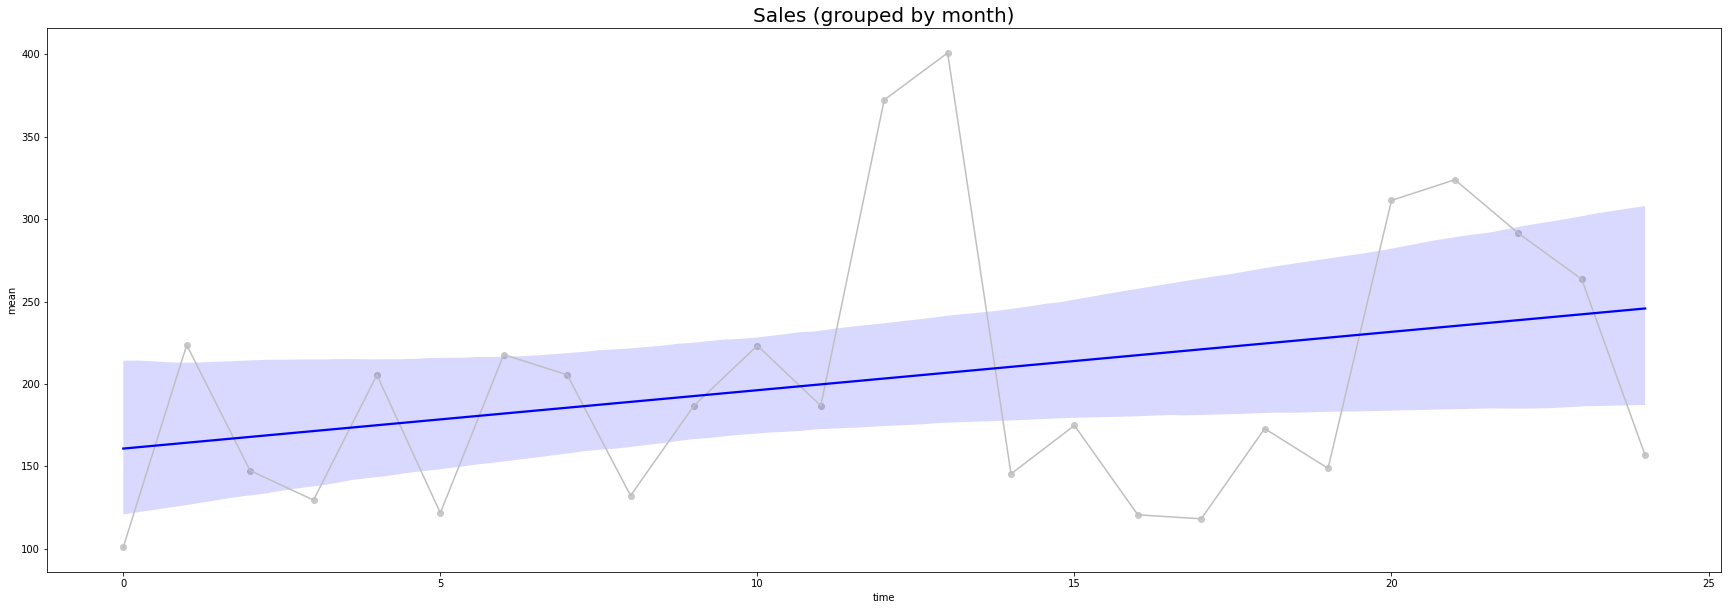

In [11]:
df_grouped_train_m = add_time(data_sales, 'date_of_day', 'M', 'sold_qty_units')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,10))
axes.plot('time', 'mean', data=df_grouped_train_m, color='0.75')
axes.set_title("Sales (grouped by month)", fontsize=20)
axes = sns.regplot(x='time', 
                   y='mean', 
                   data=df_grouped_train_m, 
                   scatter_kws=dict(color='0.75'), 
                   line_kws={"color": "blue"},
                   ax = axes)

plt.show()

##### Lag Plot 
To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.
Observations:
* The data is not random as we can some salient pattern indicating the presence of trend.
* The linear pattern along the fitted line (i.e. going upwards from left to right) is suggestive of positive autocorrelation. But the losely clustered data around the diagonal will make it hard to predict the point i given the points i-n.
* Outliers are easily discernible from the plot and this will impact the efficiency of forecasting model we will use. 

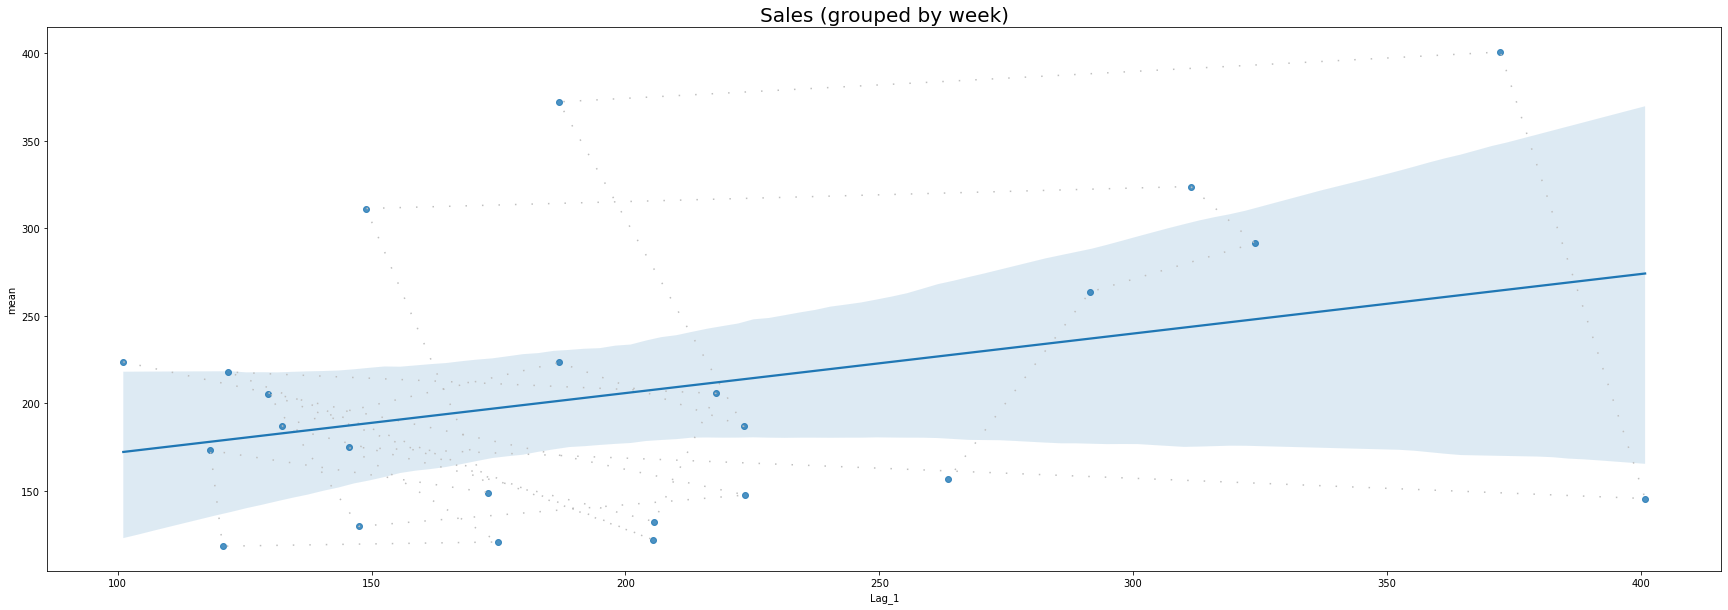

In [12]:
df_grouped_train_lag = add_lag(data_sales, 'date_of_day', 'M', 'sold_qty_units', 1)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,10))
axes.plot('Lag_1', 'mean', data=df_grouped_train_lag, color='0.75', linestyle=(0, (1, 10)))
axes.set_title("Sales (grouped by week)", fontsize=20)
axes = sns.regplot(x='Lag_1', 
                    y='mean', 
                    data=df_grouped_train_lag, 
                    ax = axes)

##### Correlation and Skewness 
The continuous plot, as the name says, is for continuous variables. We will see the distribution of probabilities and use BoxCox to understand if there is increase of correlation and decrease of skewness for each variable. In some cases the process of transforming a variable can help, depending on the model.

**Observation** 
* The variable *store_count* is moderately correlated with the sales of the products which is also intutive. Additionally the correlation coefficient change is minimal (0.1) after applying the boxcox transformation of 0.15 and 0.25. 
* It is evident from the skew value of the linear plot (-0.06) that the distribution is near to normal and hence can imporve our fit.

This is indicative of the significance of this feature for forecasting the sales.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


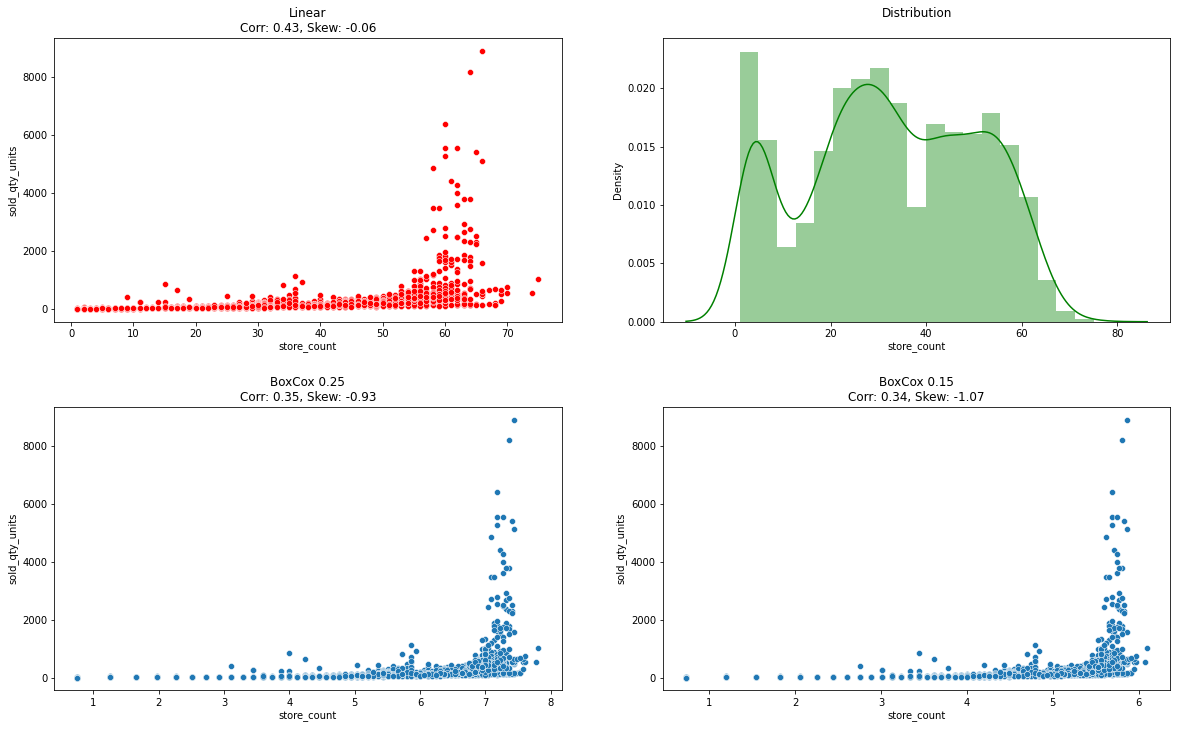

In [13]:
make_continuous_plot('store_count')

**Observation**
* The feature *unit_discount_weekly* has a very high negative skewness (-11.32) and does not improve after applying boxcox transformation.
* The correlation coefficient of this feature against the sales is also almost equal to 0 and does not change after transformation.

Having this feature in our dataset would lead to high prediction error and therefore we will discard it from our data for modelling.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


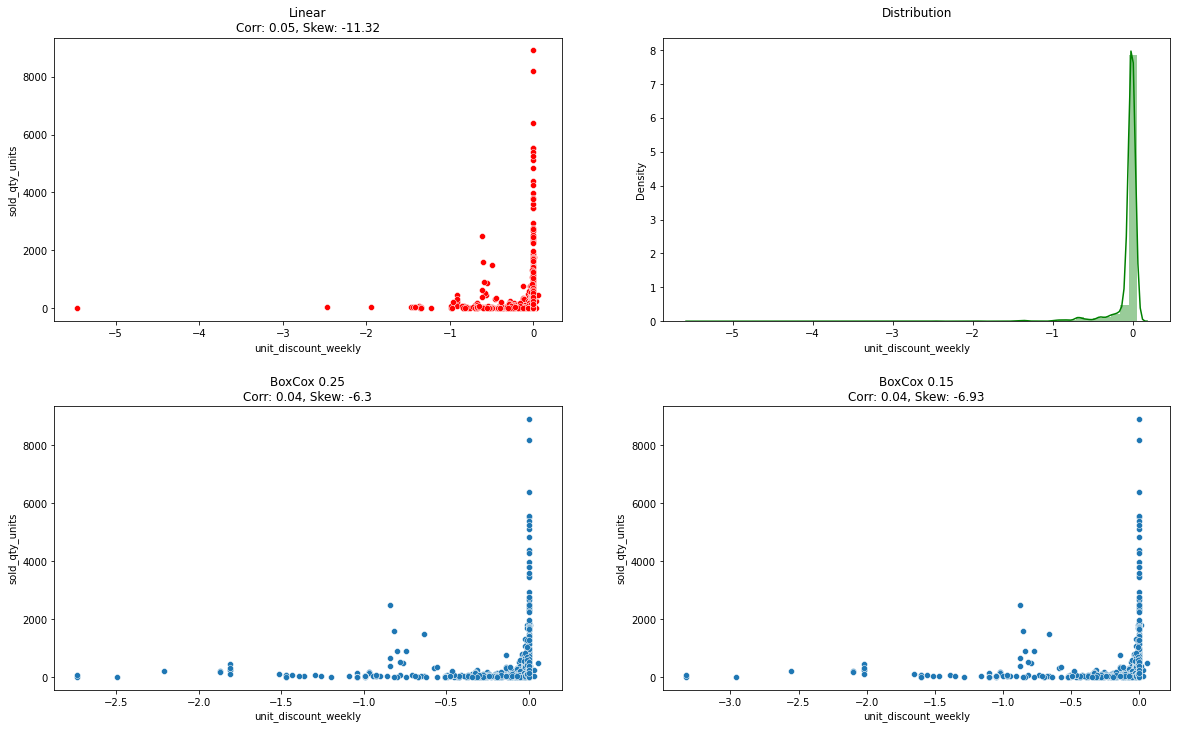

In [14]:
make_continuous_plot('unit_discount_weekly')

**Observation**
* The correlation (0.96) between the *total_cust_count* and the product sales was expected as they are highly interdependent.
* The feature is highly skewed but it decreases post boxcox transformation with the correlation coefficient still being a significant value.

Therefore we will retain this information as it is representative of our target variable.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


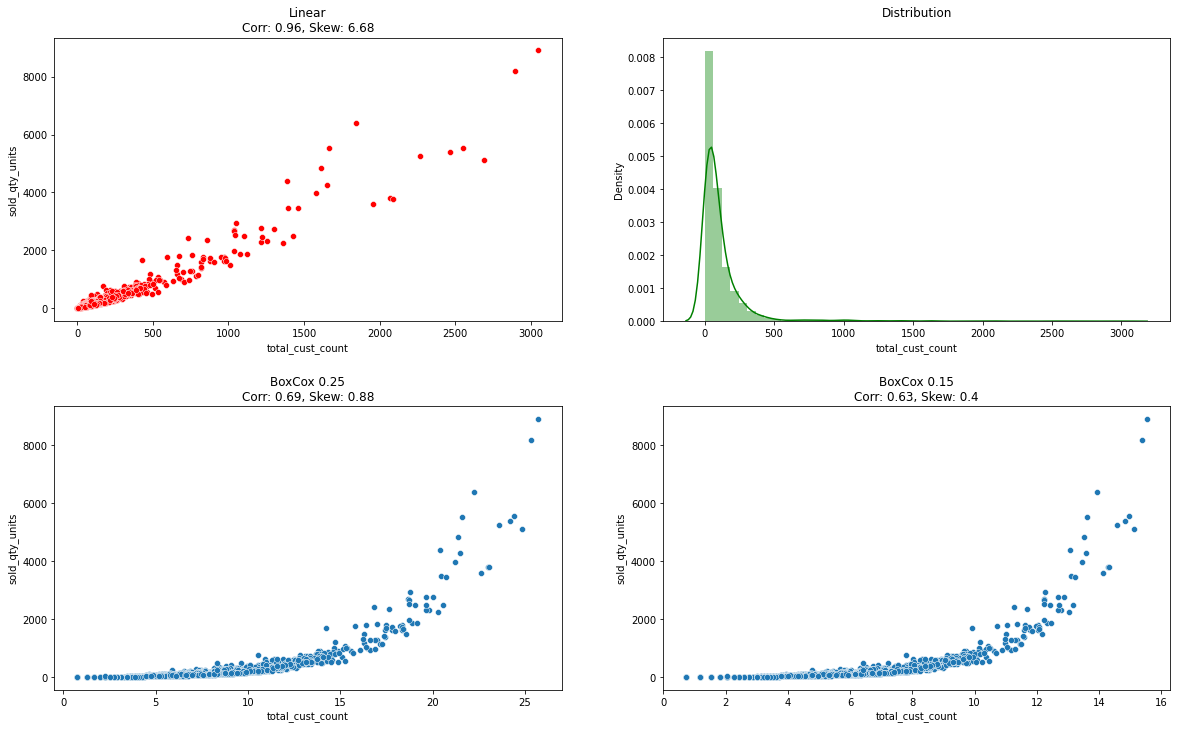

In [15]:
make_continuous_plot('total_cust_count')

##### Distribution and Quartile
The discrete plot is for finite numbers. We will use boxplot, to see the medians and interquartile ranges, and the striplot, which is a better way of seeing the distribution, even more when lots of outliers are present.

**Observation**

The sales of the products are very much clustered for 3 types of product subgroups but has a high spread along the strip of subgroup *Extras* and hence this feature will be important to distinguish the normal sales against the outliers.

C:\Users\SHRIKA~1\AppData\Local\Temp/ipykernel_22244/1855311484.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


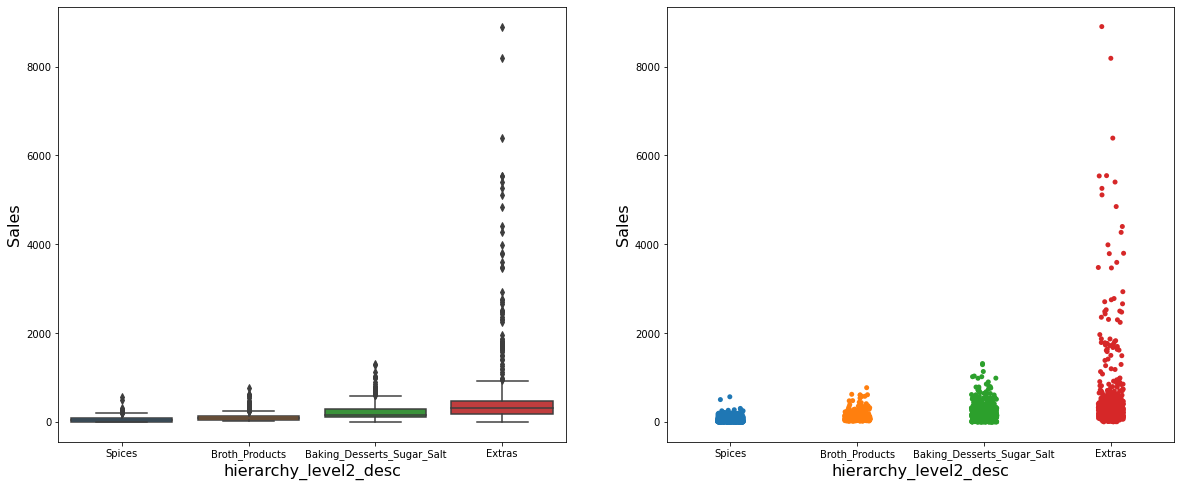

In [16]:
make_discrete_plot('hierarchy_level2_desc')

**Observation**

Same reason as explained for the field *hierarchy_level2_desc* above this feature of *hierarchy_level3_desc* is also important for predicting the sales of the products.

C:\Users\SHRIKA~1\AppData\Local\Temp/ipykernel_22244/1855311484.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


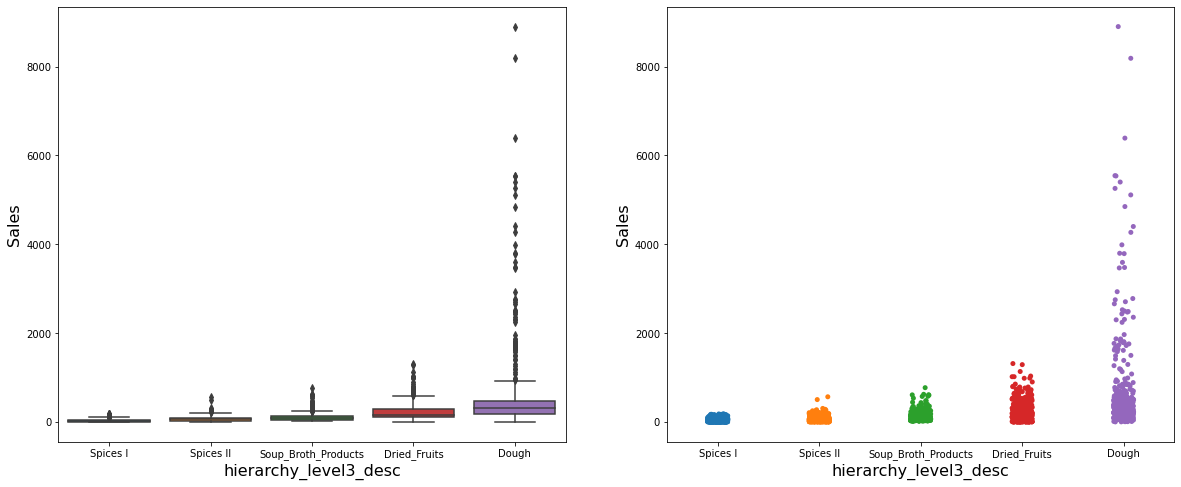

In [17]:
make_discrete_plot('hierarchy_level3_desc')

C:\Users\SHRIKA~1\AppData\Local\Temp/ipykernel_22244/1855311484.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


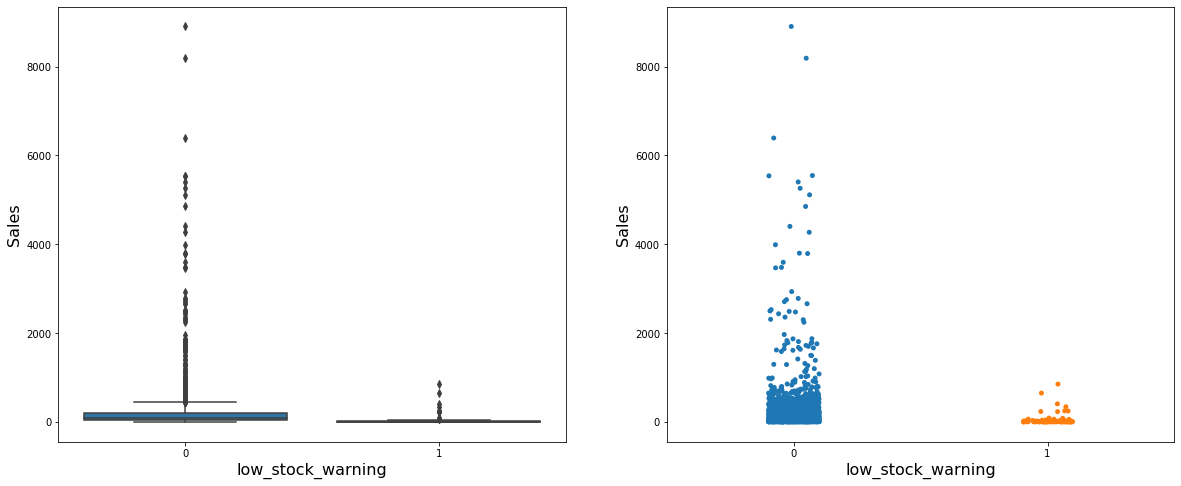

In [18]:
make_discrete_plot('low_stock_warning')

##### Correlation Matrix

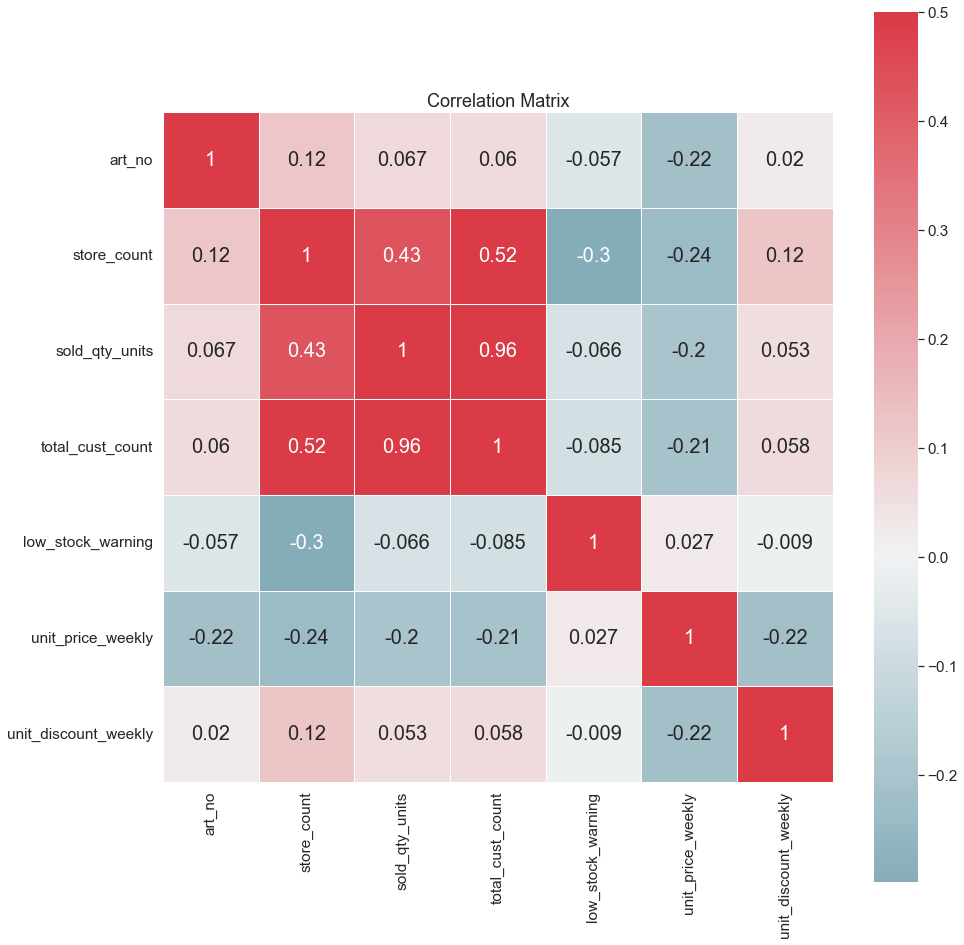

In [19]:
sns.set(style="white", font_scale=1.4)
corr = data_sales.corr()
f, ax = plt.subplots(figsize=(15, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, 
            annot=True, annot_kws={"fontsize":20})
plt.show()

In [20]:
data_sales.to_csv('../data/eda_output.csv')

##### Time Series Decomposition and Stationarity Test

In [72]:
eda_output = pd.read_csv('../data/eda_output.csv')

**Observation**  
From the STL plot we can observe that the trend component has a flat slope with some spikes and there is some salient seasonality present. Therefore let us verify the moving average sales to exploit the seasonality of the products with respect to the *hierarchy_level2* in the next section.

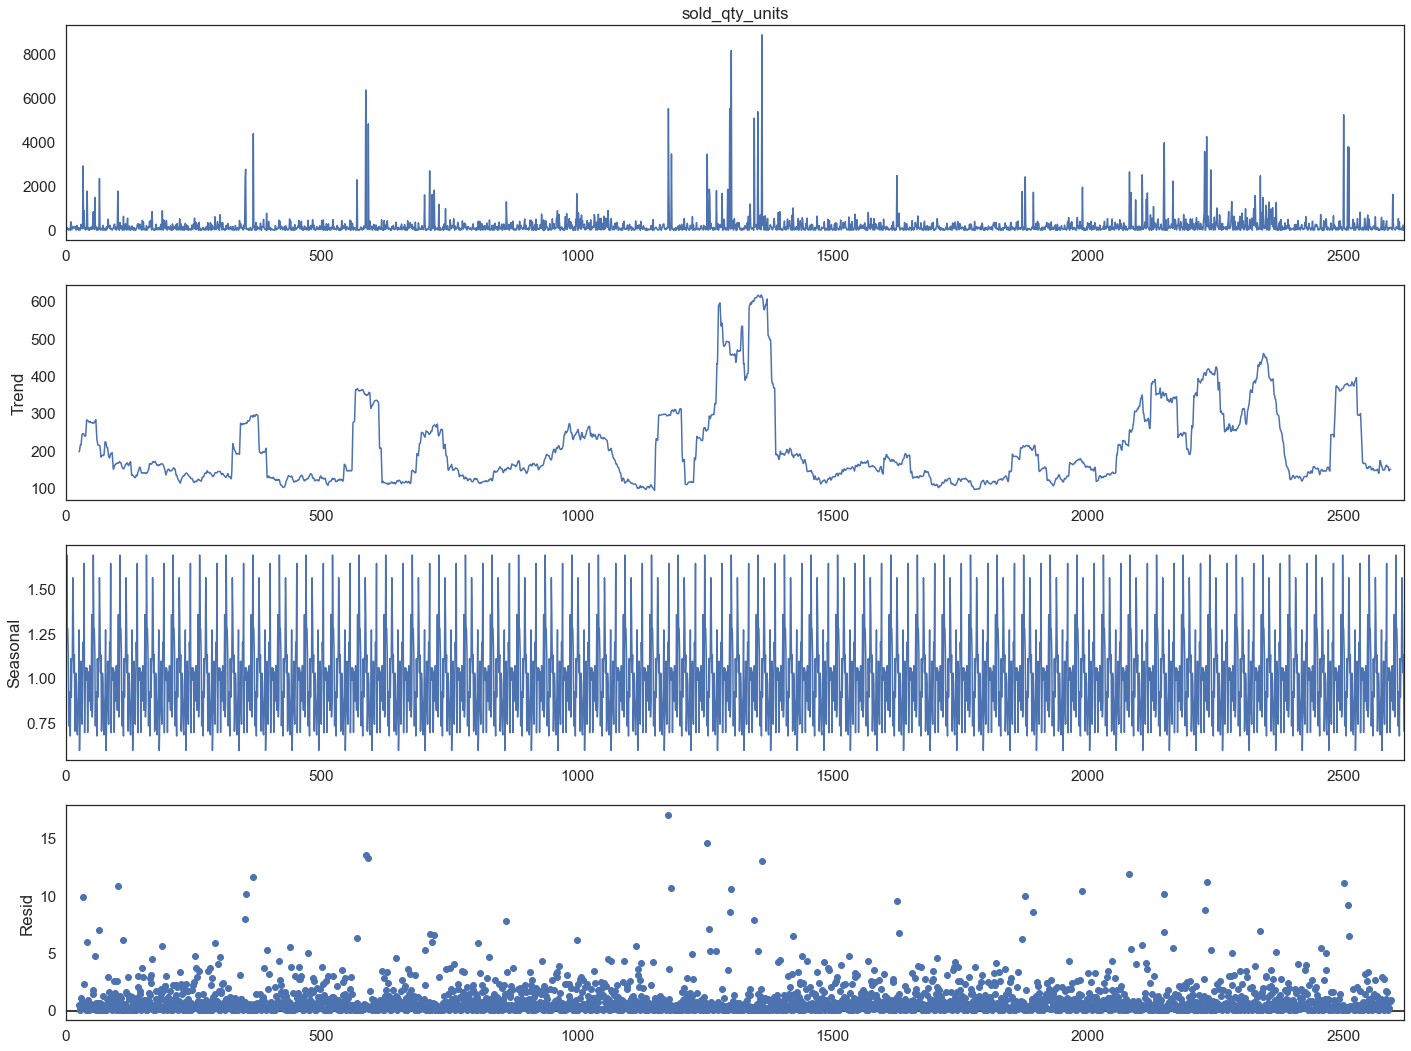

In [86]:
plt.rc('figure',figsize=(20,15))
plt.rc('font',size=20)
result = seasonal_decompose(eda_output.sold_qty_units, model='multiplicative', period=52)
fig = result.plot()

**Observation**

The adfuller test for the stationarity of the time series data shows:

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis.
* p-value <= 0.05: Reject the null hypothesis (H0).
* Running the test prints the ADF statistic value of -10. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).
* Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.



In [46]:
result = adfuller(eda_output.sold_qty_units, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.591078
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


**Observation**

* From the rolling mean plot for 10 weeks upon the product sub-category *hierarchy_level2_desc* we can observe that the sales of products belonging to the subcategories *Baking_Desserts_Sugar_Salt* and *Broth_products* are correlated. 

This correlation will make it possible to use the sales value of one variable to predict the sales of another.

* The sales of the products belonging to the subcategory *Extras* is differentiative from all other subcategories. It will be helpful if the Extras are further subclassified and with this we can circumvent the presence of such high peaks.

Text(0.5, 0, 'Time')

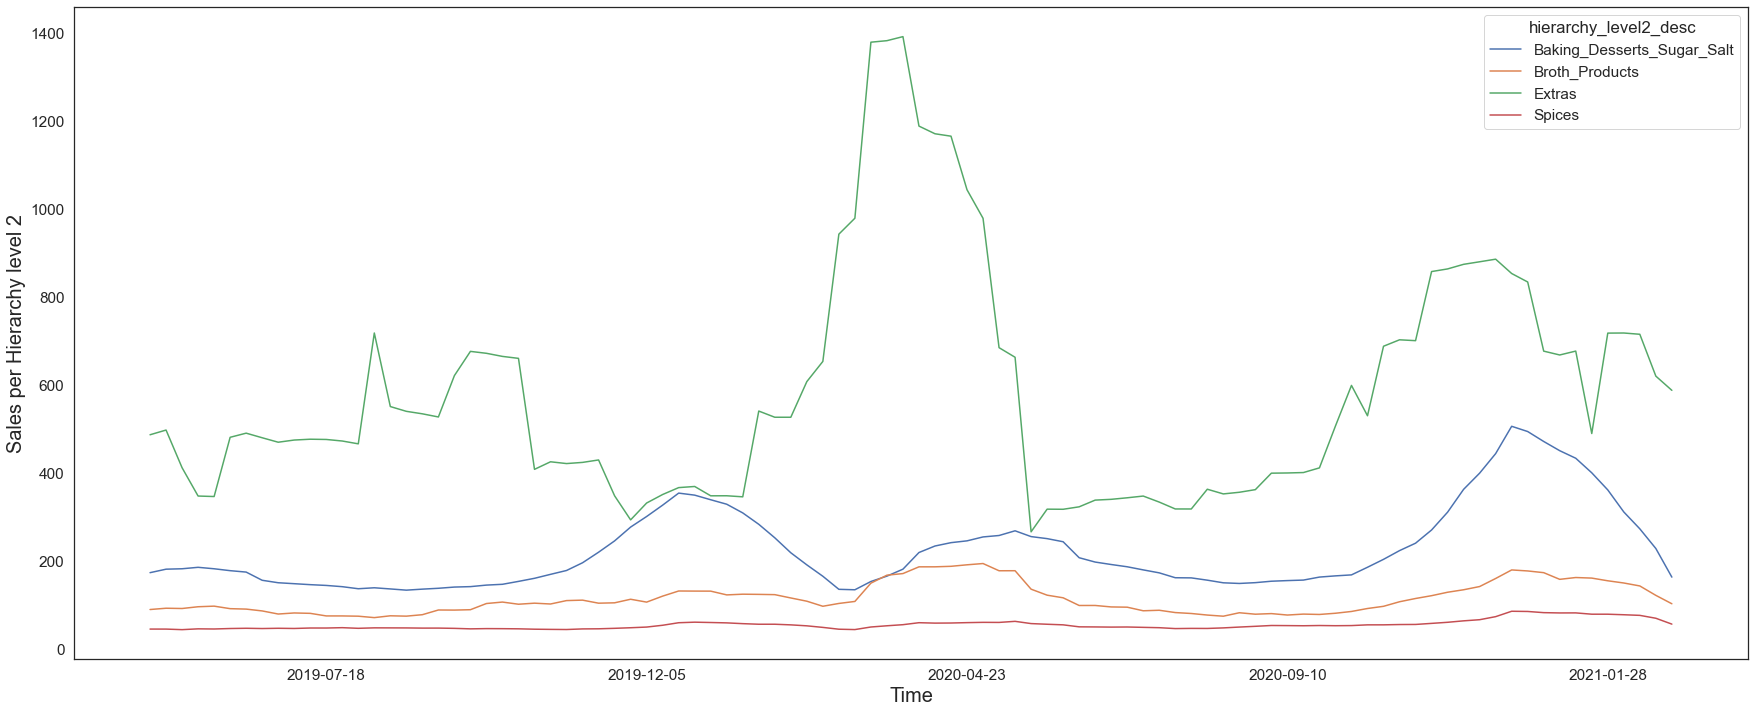

In [54]:
pivot_df = eda_output.pivot_table(index='date_of_day', columns='hierarchy_level2_desc', values='sold_qty_units')
rolling_df = pivot_df.rolling(10).mean().plot()
plt.ylabel('Sales per Hierarchy level 2', fontsize=20)
plt.xlabel('Time', fontsize=20)


##### Outlier Detection using CART

**Observation**

* Isolation Forest algorithm can be used to predict whether a certain point is an outlier or not, without the help of any labeled dataset.

* When applying an IsolationForest model, we set contamination = outliers_fraction, that is telling the model what proportion of outliers are present in the data. This is a trial/error metric. In our case we set it to 0.02.

* From the graph below we can discern the amount of outliers in our dataset can bias or influence the estimates and have an effect on the accuracy of the forecasting model.



In [108]:
outliers_fraction = float(.02)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(np.array(eda_output.sold_qty_units).reshape(-1, 1)))

model =  IsolationForest(contamination=outliers_fraction, n_estimators=50)
model.fit(data_scaled)

IsolationForest(contamination=0.02, n_estimators=50)

In [123]:
eda_output['anomaly'] = model.predict(data_scaled)
eda_output['scores']=model.decision_function(data_scaled)
anomaly=eda_output.loc[eda_output['anomaly']==-1]
anomaly_index=list(anomaly.index)
anomaly[['sold_qty_units', 'scores', 'anomaly']].head()

,sold_qty_units,scores,anomaly
34,2933.0,-0.057674,-1
42,1783.0,-0.014544,-1
57,1499.0,-0.003648,-1
66,2358.0,-0.040954,-1
102,1789.0,-0.014544,-1


In [125]:
outliers_counter = len(anomaly[anomaly['sold_qty_units'] > anomaly['sold_qty_units'].min()-1])
print("Accuracy percentage:", 100*list(anomaly['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 100.0


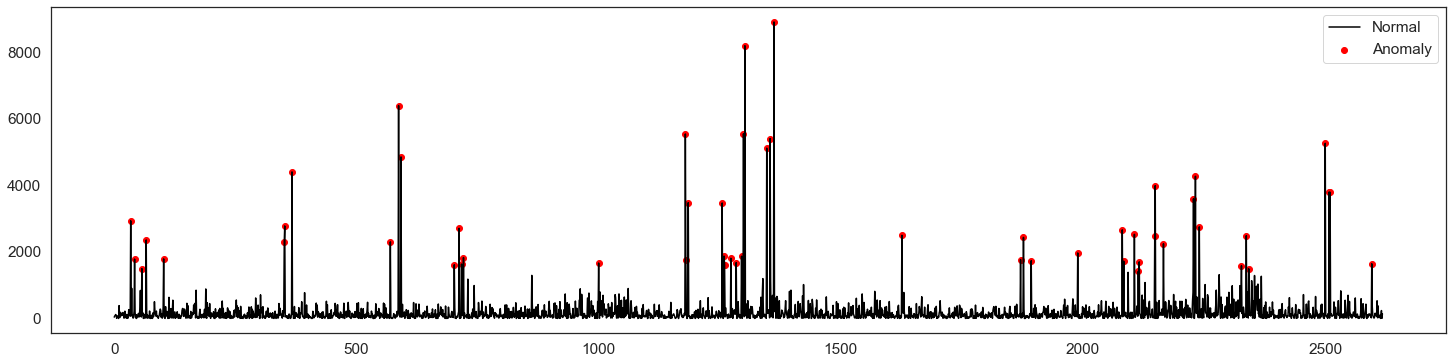

In [122]:
fig, ax = plt.subplots(figsize=(25,6))
a = eda_output.loc[eda_output['anomaly'] == -1, ['sold_qty_units']] 
ax.plot(eda_output.index, eda_output['sold_qty_units'], color='black', label = 'Normal')
ax.scatter(a.index,a['sold_qty_units'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

##### Transformation, Correlation and Outliers
We will be using LightGBM for the training pipeline for the following reasons:
* The correlation between the dependent and independent variable as we have seen above that transformations tend to alter the existing correlation.
* Some of the features in our data have negative values which when transformed will result in NaN.
* Presence of outliers in our data. 

As the LightGBM framework is a decision tree based learning algorithm there is no need of transforming or scaling the feature values. This is because at each tree level, the score of a possible split will be equal irrespective of the feature being scaled or not. Being an ensemble learner it is more robust to the outliers.

